## 作業

1. 試比較有批次標準化在 Batch_size 為 2、16、32、128、256 下的差異
2. 請嘗試將批次標準化放在 Activation 之前，並比較訓練結果
3. 請嘗試將批次標準化放在 Input Layer 之後，並比較訓練結果

## 參考資料

[批标准化(Batch Normalization)](https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/)

[Batch Normalization 原理与实战](https://zhuanlan.zhihu.com/p/34879333)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, batch_sizes, should_prenormalize=False, should_normalize_input=False,
                 neuron_numbers=(512, 256, 128,), epochs=50, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, batch_size in enumerate(batch_sizes):
        print('Experiment with batch size: {}'.format(batch_size))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], y_train.shape[-1], neuron_numbers,
                            should_prenormalize, should_normalize_input)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, should_prenormalize, should_normalize_input):
    main_input = Input(shape=input_shape, name='main_input')
    hidden_input = BatchNormalization()(main_input) if should_normalize_input and not should_prenormalize else main_input
    for i, neuron_number in enumerate(neuron_numbers):
        dense_layer, bn_layer = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}'), BatchNormalization()
        hidden_input = dense_layer(bn_layer(hidden_input)) if should_prenormalize else bn_layer(dense_layer(hidden_input))
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, batch_sizes):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], batch_sizes[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, batch_size):
    plt.plot(train_history.history[train_name], '-', label='exp-bz-{}'.format(batch_size), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp-bz-{}'.format(batch_size), color=color)

## 以不同的批次大小觀看學習曲線的走勢

In [7]:
# 設定超參數
batch_sizes = (16, 64, 256, 1024, 2048,) # 註：批次大小為 2 時太過耗時

# 設定繪圖參數
colors = ['r', 'g', 'b', 'y', 'm']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, batch_sizes)

Experiment with batch size: 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)     

Epoch 13/50
 - 26s - loss: 1.0700 - acc: 0.6191 - val_loss: 1.5645 - val_acc: 0.4739
Epoch 14/50
 - 24s - loss: 1.0381 - acc: 0.6326 - val_loss: 1.6418 - val_acc: 0.4447
Epoch 15/50
 - 25s - loss: 1.0241 - acc: 0.6383 - val_loss: 1.5369 - val_acc: 0.4813
Epoch 16/50
 - 25s - loss: 0.9953 - acc: 0.6480 - val_loss: 1.6207 - val_acc: 0.4476
Epoch 17/50
 - 25s - loss: 0.9922 - acc: 0.6476 - val_loss: 1.5615 - val_acc: 0.4770
Epoch 18/50
 - 25s - loss: 0.9722 - acc: 0.6544 - val_loss: 1.6620 - val_acc: 0.4582
Epoch 19/50
 - 24s - loss: 0.9404 - acc: 0.6668 - val_loss: 1.6028 - val_acc: 0.4818
Epoch 20/50
 - 25s - loss: 0.9218 - acc: 0.6749 - val_loss: 1.6154 - val_acc: 0.4642
Epoch 21/50
 - 25s - loss: 0.9064 - acc: 0.6783 - val_loss: 1.5777 - val_acc: 0.4792
Epoch 22/50
 - 25s - loss: 0.8815 - acc: 0.6858 - val_loss: 1.5171 - val_acc: 0.4975
Epoch 23/50
 - 25s - loss: 0.8802 - acc: 0.6883 - val_loss: 1.6718 - val_acc: 0.4624
Epoch 24/50
 - 25s - loss: 0.8511 - acc: 0.6985 - val_loss: 1.605

 - 12s - loss: 0.2618 - acc: 0.9219 - val_loss: 2.2541 - val_acc: 0.4556
Epoch 43/50
 - 13s - loss: 0.2552 - acc: 0.9239 - val_loss: 2.2736 - val_acc: 0.4753
Epoch 44/50
 - 12s - loss: 0.2405 - acc: 0.9295 - val_loss: 2.2749 - val_acc: 0.4672
Epoch 45/50
 - 11s - loss: 0.2259 - acc: 0.9343 - val_loss: 2.2894 - val_acc: 0.4812
Epoch 46/50
 - 11s - loss: 0.2100 - acc: 0.9405 - val_loss: 2.3080 - val_acc: 0.4743
Epoch 47/50
 - 12s - loss: 0.1990 - acc: 0.9431 - val_loss: 2.3046 - val_acc: 0.4708
Epoch 48/50
 - 12s - loss: 0.1867 - acc: 0.9487 - val_loss: 2.4558 - val_acc: 0.4677
Epoch 49/50
 - 12s - loss: 0.1830 - acc: 0.9480 - val_loss: 2.4497 - val_acc: 0.4605
Epoch 50/50
 - 12s - loss: 0.1757 - acc: 0.9505 - val_loss: 2.5499 - val_acc: 0.4525
Experiment with batch size: 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
________________

Epoch 5/50
 - 8s - loss: 1.6263 - acc: 0.4345 - val_loss: 1.7180 - val_acc: 0.4064
Epoch 6/50
 - 8s - loss: 1.5821 - acc: 0.4494 - val_loss: 1.6718 - val_acc: 0.4177
Epoch 7/50
 - 8s - loss: 1.5448 - acc: 0.4649 - val_loss: 1.6491 - val_acc: 0.4193
Epoch 8/50
 - 8s - loss: 1.5136 - acc: 0.4744 - val_loss: 1.6241 - val_acc: 0.4296
Epoch 9/50
 - 8s - loss: 1.4837 - acc: 0.4856 - val_loss: 1.6052 - val_acc: 0.4374
Epoch 10/50
 - 8s - loss: 1.4590 - acc: 0.4943 - val_loss: 1.5948 - val_acc: 0.4411
Epoch 11/50
 - 8s - loss: 1.4352 - acc: 0.5029 - val_loss: 1.5806 - val_acc: 0.4423
Epoch 12/50
 - 8s - loss: 1.4135 - acc: 0.5091 - val_loss: 1.5646 - val_acc: 0.4489
Epoch 13/50
 - 8s - loss: 1.3924 - acc: 0.5178 - val_loss: 1.5565 - val_acc: 0.4532
Epoch 14/50
 - 8s - loss: 1.3728 - acc: 0.5258 - val_loss: 1.5518 - val_acc: 0.4561
Epoch 15/50
 - 8s - loss: 1.3539 - acc: 0.5314 - val_loss: 1.5369 - val_acc: 0.4598
Epoch 16/50
 - 8s - loss: 1.3354 - acc: 0.5382 - val_loss: 1.5378 - val_acc: 0.45

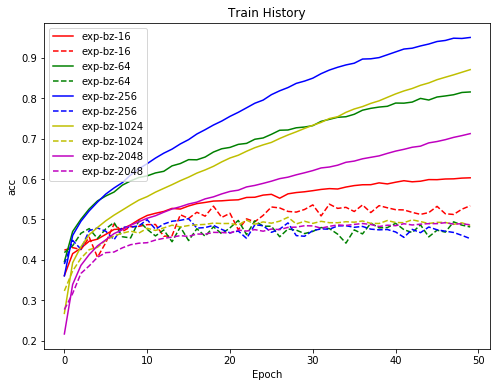

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, batch_sizes)

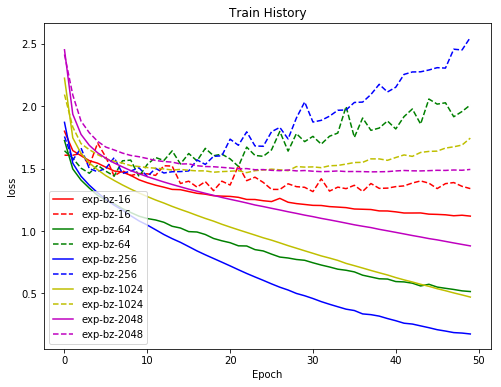

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, batch_sizes)

## 將批次標準化放在啟動函數之前並觀看學習曲線的走勢

In [11]:
# 設定超參數
batch_sizes = (1024,)
should_prenormalize = True

# 設定繪圖參數
colors = ['r']

In [12]:
train_histories = train_models(X_train, y_train, X_test, y_test, batch_sizes, should_prenormalize=should_prenormalize)

Experiment with batch size: 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)   

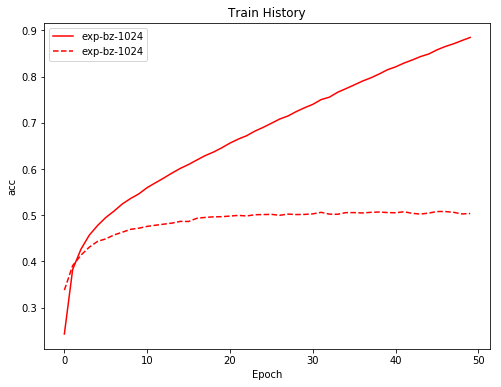

In [13]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, batch_sizes)

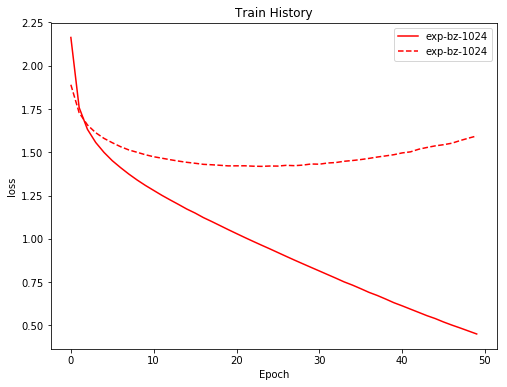

In [14]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, batch_sizes)

## 將批次標準化放在輸入層之後並觀看學習曲線的走勢

In [15]:
# 設定超參數
batch_sizes = (1024,)
should_normalize_input = True

# 設定繪圖參數
colors = ['r']

In [16]:
train_histories = train_models(X_train, y_train, X_test, y_test, batch_sizes, should_normalize_input=should_normalize_input)

Experiment with batch size: 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)   

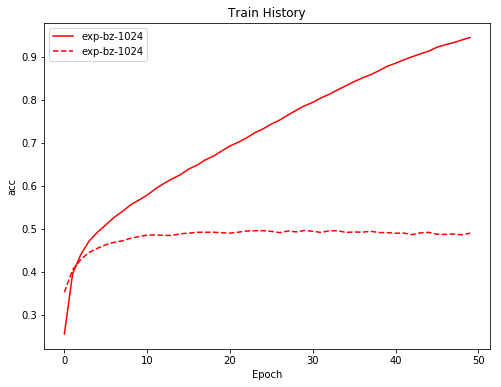

In [17]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, batch_sizes)

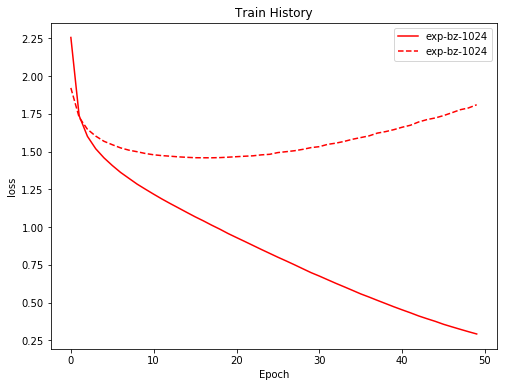

In [18]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, batch_sizes)